## Climate Analysis and Exploration
To begin, use Python and SQLAlchemy to do basic climate analysis and data exploration of your climate database. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

In [2]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import and_, or_

In [4]:
# Set Database Connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found (table names)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Explore Database

In [9]:
#Inspect tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Using inspector to print column names within table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Using inspector to print column names within table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

1) Design a query to retrieve the last 12 months of precipitation data and plot the results


In [12]:
# Get date format
date_format = session.query(Measurement.date).limit(3).all()
for date in date_format:
    print(date)

('2010-01-01',)
('2010-01-02',)
('2010-01-03',)


2) Calculate the date 1 year ago from the last data point in the database


In [13]:
# Date format = Year, Month, Day
# Find latest date in measurement table
latest_date = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())
print(latest_date)

('2017-08-23',)


In [14]:
# Extract string from query object
latest_date = list(np.ravel(latest_date))[0]
print(latest_date)

2017-08-23


In [15]:
# Convert date string to datetime object
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date

datetime.datetime(2017, 8, 23, 0, 0)

In [29]:
# Get year, month, and day as integers
latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_day = int(dt.datetime.strftime(latest_date, '%d'))

print(latest_year)
print(latest_month)
print(latest_day)

2017
8
23


In [30]:
# Calculate one year before latest date
year_before_date = dt.date(latest_year, latest_month, latest_day) - dt.timedelta(days=365)
print(year_before_date)

2016-08-23


3) Perform a query to retrieve the data and precipitation scores


In [31]:
# Query for precipitation data from Aug. 23, 2016 - Aug. 23, 2017
Prcp_Data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date >= year_before_date)
                  .order_by(Measurement.date)
                  .all())

4) Save the query results as a Pandas DataFrame and set the index to the date column


In [32]:
# Pandas df for precipitation data from Aug. 23, 2016 - Aug. 23, 2017
Prcp_df = pd.DataFrame(Prcp_Data)
Prcp_df = Prcp_df.set_index('date')
Prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


5) Sort the dataframe by date


In [33]:
# Pandas df sorted by date
Prcp_df = Prcp_df.sort_index(ascending=True)
Prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


6) Use Pandas Plotting with Matplotlib to plot the data

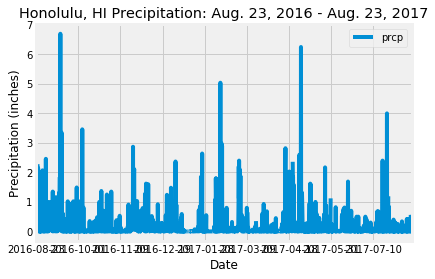

In [34]:
# Plot precipitation data over the last 12 months
Prcp_df.plot()
plt.title("Honolulu, HI Precipitation: Aug. 23, 2016 - Aug. 23, 2017")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.savefig("Images/HI_prcp.png")
plt.show()

7) Use Pandas to calcualte the summary statistics for the precipitation data

In [35]:
# Use .describe for summary statistics table
Prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


8) Design a query to show how many stations are available in this dataset?


In [36]:
# Count stations in the station table
stations_count = session.query(Station).count()
print(f"Station Count: {stations_count}")

Station Count: 9


9) What are the most active stations? (i.e. what stations have the most rows)? List the stations and the counts in descending order.


In [37]:
most_active = (session
              .query(Measurement.station, func.count(Measurement.station))
              .group_by(Measurement.station)
              .order_by(func.count(Measurement.station).desc())
              .all())
               
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

10) Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?


In [38]:
# Find min, max, and avg for most active station USC00519281.
station_id = 'USC00519281'
temps = (session
        .query(
            func.min(Measurement.tobs),
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs))
        .filter(Measurement.station == station_id)
        .all()
        )
    
print(temps)

[(54.0, 85.0, 71.66378066378067)]


In [39]:
# Print station values
print(f"Most active station is {station_id}")
print(f"Min Temp: {temps[0][0]}(F)")
print(f"Max Temp: {temps[0][1]}(F)")
print(f"Avg Temp: {temps[0][2]}(F)")

Most active station is USC00519281
Min Temp: 54.0(F)
Max Temp: 85.0(F)
Avg Temp: 71.66378066378067(F)


11)  Choose the station with the highest number of temperature observations. Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [40]:
# Last 12 months for station_id = 'USC00519281'
station_id = 'USC00519281'
temp_obsv = (session.query(Measurement.date, Measurement.tobs)
                  .filter(Measurement.date >= year_before_date)
                  .filter(Measurement.station == station_id)
                  .order_by(Measurement.date)
                  .all())

temp_obsv_df = pd.DataFrame(temp_obsv, columns = ["date", "temperature"])
temp_obsv_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


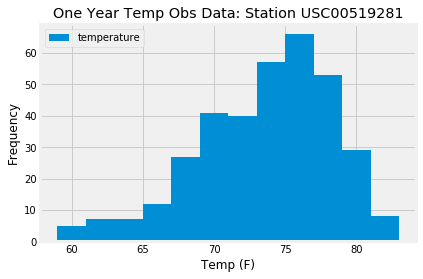

In [41]:
# Plot data into histogram
fig, ax = plt.subplots()
temp_obsv_df.plot.hist(ax=ax, bins = 12)
ax.set_xlabel("Temp (F)")
ax.set_ylabel("Frequency")
plt.title (f"One Year Temp Obs Data: Station {station_id}")
plt.savefig("Images/USC00519281_tobs_hist.png")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
